In [269]:
import graphviz
import numpy as np
import pandas as pd
from collections import OrderedDict
from sortedcollections import OrderedSet

path = set()

In [270]:
start = 'u'
V = 'uvwxyz'
edges = {
    ('u', 'w'): 2,
    ('u', 'v'): 3,
    ('u', 'x'): 6,
    ('v', 'x'): 3,
    ('v', 'w'): 5,
    ('x', 'w'): 5,
    ('x', 'y'): 9,
    ('w', 'z'): 3,
    ('w', 'y'): 1,
    ('y', 'z'): 6,
}

# start = 'u'
# V = 'uvwxyz'
# edges = {
#     ('u', 'x'): 5,
#     ('u', 'w'): 3,
#     ('u', 'v'): 7,
#     ('w', 'x'): 4,
#     ('w', 'v'): 3,
#     ('w', 'y'): 8,
#     ('x', 'y'): 7,
#     ('x', 'z'): 9,
#     ('v', 'y'): 4,
#     ('y', 'z'): 2,
# }

In [271]:
class BiDict(OrderedDict):
    def __setitem__(self, key: tuple, value):
        if key in self:
            del self[key]
        if value in self:
            del self[value]

        OrderedDict.__setitem__(self, key, value)
        OrderedDict.__setitem__(self, key[::-1], value)
        
    def __delitem__(self, key):
        OrderedDict.__delitem__(self, self[key])
        OrderedDict.__delitem__(self, key)

E = BiDict({k: v for k, v in edges.items()})
E

BiDict([(('u', 'w'), 2),
        (('w', 'u'), 2),
        (('u', 'v'), 3),
        (('v', 'u'), 3),
        (('u', 'x'), 6),
        (('x', 'u'), 6),
        (('v', 'x'), 3),
        (('x', 'v'), 3),
        (('v', 'w'), 5),
        (('w', 'v'), 5),
        (('x', 'w'), 5),
        (('w', 'x'), 5),
        (('x', 'y'), 9),
        (('y', 'x'), 9),
        (('w', 'z'), 3),
        (('z', 'w'), 3),
        (('w', 'y'), 1),
        (('y', 'w'), 1),
        (('y', 'z'), 6),
        (('z', 'y'), 6)])

In [272]:
lookup = OrderedDict({u: OrderedDict({v: E.get((u, v), np.inf) for v in sorted(set(V) - set(u))}) for u in sorted(V)})
lookup

OrderedDict([('u',
              OrderedDict([('v', 3),
                           ('w', 2),
                           ('x', 6),
                           ('y', inf),
                           ('z', inf)])),
             ('v',
              OrderedDict([('u', 3),
                           ('w', 5),
                           ('x', 3),
                           ('y', inf),
                           ('z', inf)])),
             ('w',
              OrderedDict([('u', 2), ('v', 5), ('x', 5), ('y', 1), ('z', 3)])),
             ('x',
              OrderedDict([('u', 6),
                           ('v', 3),
                           ('w', 5),
                           ('y', 9),
                           ('z', inf)])),
             ('y',
              OrderedDict([('u', inf),
                           ('v', inf),
                           ('w', 1),
                           ('x', 9),
                           ('z', 6)])),
             ('z',
              OrderedDict([('u', inf),
 

In [273]:
class Node:
    def __init__(self, value, dist=0, parent=None):
        self.value = value
        self.dist = dist      # the estimate distance (cost) value from the initiator
        self.parent = parent  # predecessor node in the spanning tree rooted at the initiator

    def __repr__(self):
        return self.value

    def __str__(self):
        return str(np.inf) if self.dist == np.inf else f"{self.dist},{self.parent.value}"

    def __getitem__(self, q):
        """Returns the dist p to q if connected; otherwise, infinity"""
        return lookup[self.value][q.value]

In [274]:
graph = OrderedSet(map(lambda u: Node(value=u, parent=Node(value=start)), sorted(set(V) - set(start))))
visited = OrderedSet({Node(value=start)})  # set of nodes whose least-cost-path is definitively known
table = OrderedDict([("N'", [start])])

print(f"Graph: {graph}", f"Visited: {visited}", f"Table: {table}", sep='\n')

Graph: OrderedSet([v, w, x, y, z])
Visited: OrderedSet([u])
Table: OrderedDict([("N'", ['u'])])


In [275]:
for u in graph:
    u.dist = lookup[start][u.value]
    table[f"D({u.value}),p({u.value})"] = [str(u)]

table

OrderedDict([("N'", ['u']),
             ('D(v),p(v)', ['3,u']),
             ('D(w),p(w)', ['2,u']),
             ('D(x),p(x)', ['6,u']),
             ('D(y),p(y)', ['inf']),
             ('D(z),p(z)', ['inf'])])

In [276]:
for row in range(1, len(V)):
    # NOTE: Python's min() function selects the first occurrence if values are equal; meaning, the node's `q` parent won't change
    p = min(graph-visited, key=lambda u: u.dist)

    visited.add(p)
    path.add((p.parent.value, p.value))  # NOTE: used for graphviz
    
    table["N'"].append(''.join(map(repr, visited)))

    for col, q in enumerate(graph):
        header = f"D({q.value}),p({q.value})"

        if q in visited:
            table[header].append("---")
            continue

        print(f"[{row}, {col}] -- D({q.value}) = min(D({q.value}), D({p.value}) + C({p.value}, {q.value})) =",
              f"min({q.dist}, {p.dist} + {p[q]}) =",
              f"min({q.dist}, {p.dist + p[q]}) =",
              min(q.dist, p.dist + p[q]))

        if p.dist + p[q] < q.dist:
            q.dist = p.dist + p[q]
            q.parent = p

        table[header].append(str(q))

table

[1, 0] -- D(v) = min(D(v), D(w) + C(w, v)) = min(3, 2 + 5) = min(3, 7) = 3
[1, 2] -- D(x) = min(D(x), D(w) + C(w, x)) = min(6, 2 + 5) = min(6, 7) = 6
[1, 3] -- D(y) = min(D(y), D(w) + C(w, y)) = min(inf, 2 + 1) = min(inf, 3) = 3
[1, 4] -- D(z) = min(D(z), D(w) + C(w, z)) = min(inf, 2 + 3) = min(inf, 5) = 5
[2, 2] -- D(x) = min(D(x), D(v) + C(v, x)) = min(6, 3 + 3) = min(6, 6) = 6
[2, 3] -- D(y) = min(D(y), D(v) + C(v, y)) = min(3, 3 + inf) = min(3, inf) = 3
[2, 4] -- D(z) = min(D(z), D(v) + C(v, z)) = min(5, 3 + inf) = min(5, inf) = 5
[3, 2] -- D(x) = min(D(x), D(y) + C(y, x)) = min(6, 3 + 9) = min(6, 12) = 6
[3, 4] -- D(z) = min(D(z), D(y) + C(y, z)) = min(5, 3 + 6) = min(5, 9) = 5
[4, 2] -- D(x) = min(D(x), D(z) + C(z, x)) = min(6, 5 + inf) = min(6, inf) = 6


OrderedDict([("N'", ['u', 'uw', 'uwv', 'uwvy', 'uwvyz', 'uwvyzx']),
             ('D(v),p(v)', ['3,u', '3,u', '---', '---', '---', '---']),
             ('D(w),p(w)', ['2,u', '---', '---', '---', '---', '---']),
             ('D(x),p(x)', ['6,u', '6,u', '6,u', '6,u', '6,u', '---']),
             ('D(y),p(y)', ['inf', '3,w', '3,w', '---', '---', '---']),
             ('D(z),p(z)', ['inf', '5,w', '5,w', '5,w', '---', '---'])])

In [277]:
print(pd.DataFrame(table).to_markdown(tablefmt="rounded_grid"))

╭────┬────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│    │ N'     │ D(v),p(v)   │ D(w),p(w)   │ D(x),p(x)   │ D(y),p(y)   │ D(z),p(z)   │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  0 │ u      │ 3,u         │ 2,u         │ 6,u         │ inf         │ inf         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  1 │ uw     │ 3,u         │ ---         │ 6,u         │ 3,w         │ 5,w         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  2 │ uwv    │ ---         │ ---         │ 6,u         │ 3,w         │ 5,w         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  3 │ uwvy   │ ---         │ ---         │ 6,u         │ ---         │ 5,w         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  4 │ uwvyz  │ ---         │ ---         │ 6,u       

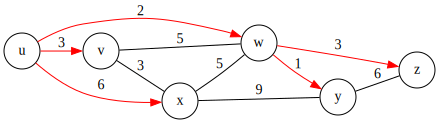

In [278]:
sptree = graphviz.Graph("Dijkstra's Link State Algorithm",
                        filename='spanning_tree',
                        graph_attr={'rankdir': 'LR'},
                        node_attr={'shape': 'circle'})

[sptree.node(v) for v in V]
[sptree.edge(u, v, dir='forward', label=str(E[(u, v)]), color="Red") for (u, v) in path]
[sptree.edge(u, v, label=str(E[(u, v)])) for (u, v) in edges if {u, v} not in map(set, path)]

sptree